# Image Clustering based on Image Features

Image feature extraction is the task of extracting semantically meaningful features given an image. This has many use cases, including image similarity and image retrieval. Moreover, most computer vision models can be used for image feature extraction, where one can remove the task-specific head (image classification, object detection etc) and get the features. These features are very useful on a higher level: edge detection, corner detection and so on. They may also contain information about the real world (e.g. what a cat looks like) depending on how deep the model is. Therefore, these outputs can be used to train new classifiers on a specific dataset. 

[Read more](https://huggingface.co/docs/transformers/main/en/tasks/image_feature_extraction)

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

rc_params = {
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 9,
    'figure.figsize': (6, 4),
}

plt.rcParams.update(rc_params)

In [2]:
from transformers import AutoImageProcessor, AutoModel
from accelerate.test_utils.testing import get_backend

DEVICE, _, _ = get_backend()
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)

/Users/micheledinelli/github/aculei/aculei-ai/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
df = pd.read_csv('data/archive.csv', index_col=1)

In [4]:
def infer(image):
  inputs = processor(image, return_tensors="pt").to(DEVICE)
  outputs = model(**inputs)
  return outputs.pooler_output

In [5]:
dirs = [path for path in os.listdir("images/archive") if os.path.isdir(os.path.join("images/archive", path))]
image_embeddings = []
image_paths = []

for dir in dirs:
    img_paths = [os.path.join("images/archive", dir, path) for path in os.listdir(os.path.join("images/archive", dir)) if path.endswith(".jpg")]
    image_paths.extend(img_paths)
    imgs = [Image.open(path) for path in img_paths if path.endswith(".jpg")]

    for image in imgs:
        image_embedding = infer(image)
        image_embeddings.append(image_embedding.cpu().detach().numpy())

In [6]:
embeddings = np.concatenate([e for e in image_embeddings], axis=0)

What an image looks like under the hood

In [28]:
embeddings[0]

array([ 0.11339514,  0.46531028, -0.16985768,  0.7041143 , -0.6851812 ,
       -0.43987012, -0.245823  , -0.44597146,  0.32189098,  0.2867004 ,
       -0.05003003,  0.23795229,  0.294617  , -0.11993403,  0.6110174 ,
        0.51748675, -0.11187854, -0.30512667, -0.20911357,  0.26541498,
       -0.12158056,  0.04818392,  0.17336036,  0.03870008, -0.41799828,
        0.0192749 , -0.01967355,  0.30747637, -0.35584915, -0.64267284,
        0.33968318,  0.2507654 ,  0.6798144 , -0.1469147 ,  0.02598643,
       -0.63769996, -0.46427584,  0.36327124,  0.62666744,  0.90453875,
        0.43676695, -0.48575008, -0.48383135, -0.552313  ,  0.17772688,
        0.464665  ,  0.24704143,  0.50261194, -0.15198846, -0.52404773,
       -0.09779581,  0.49864247, -0.23080821,  0.46072954,  0.29247114,
        0.28071818, -0.20732248,  0.39951494, -0.41325605, -0.31708518,
        0.6104944 ,  0.50996363, -0.17828134, -0.26903284, -0.42436007,
       -0.36521298, -0.70951855,  0.6960464 , -0.6687517 , -0.32

Let's reduce dimensions using Principal Component Analysis, then scale embeddings and cluster them

In [7]:
pca = PCA(n_components=3)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)

scaler = StandardScaler()
scaler.fit(pca_embeddings)
scaled_embeddings = scaler.transform(pca_embeddings)

We have to find out which k is the best one so we proceed with Elbow Method, testing for multiple k values

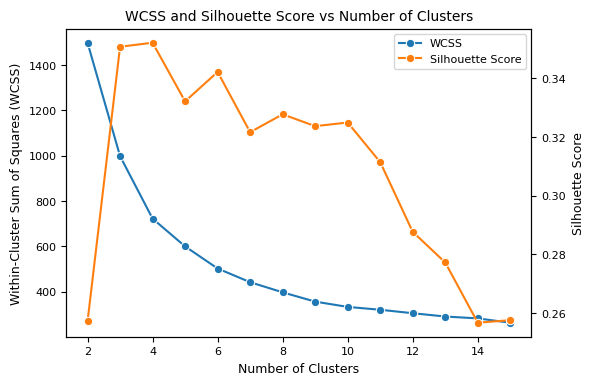

In [25]:
ks = range(2, 16)
silhouette_scores = []
wcss = []   

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_embeddings)
    labels = kmeans.labels_
    # print(f"Silhouette score for k={k}: {silhouette_score(embeddings, labels)}")
    # print(f"WCSS for k={k}: {kmeans.inertia_}")
    silhouette_scores.append(silhouette_score(scaled_embeddings, labels))
    wcss.append(kmeans.inertia_)

fig, ax1 = plt.subplots()

sns.lineplot(x=ks, y=wcss, ax=ax1, marker="o", color=sns.color_palette("tab10")[0] , label="WCSS")
ax1.set_ylabel("Within-Cluster Sum of Squares (WCSS)")

ax2 = ax1.twinx()
sns.lineplot(x=ks, y=silhouette_scores, ax=ax2, marker="o", color=sns.color_palette("tab10")[1], label="Silhouette Score")
ax2.set_ylabel("Silhouette Score")

ax1.set_xlabel("Number of Clusters")
ax1.set_title("WCSS and Silhouette Score vs Number of Clusters")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best", fontsize=8)
ax2.legend_.remove()

plt.show()

Looks like something between 3 and 8 should be good

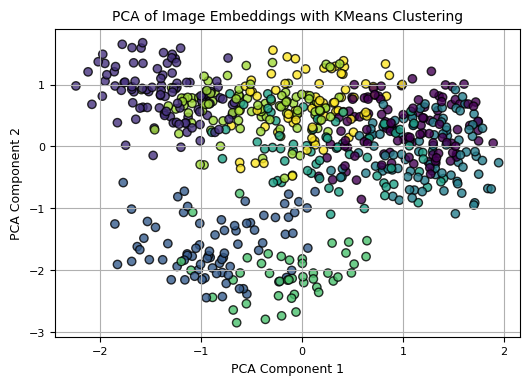

In [20]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_embeddings)

plt.scatter(scaled_embeddings[:, 0], scaled_embeddings[:, 1], c=clusters, cmap='viridis', alpha=0.8, edgecolors='black')

# for i, path in enumerate(image_paths):
#     animal = df.loc[path.split('/')[-1]].loc['predicted_animal']
#     plt.annotate(animal, (pca_embeddings[i, 0] - 0.05, pca_embeddings[i, 1] + 0.22), fontsize=8, color='black')

plt.title("PCA of Image Embeddings with KMeans Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

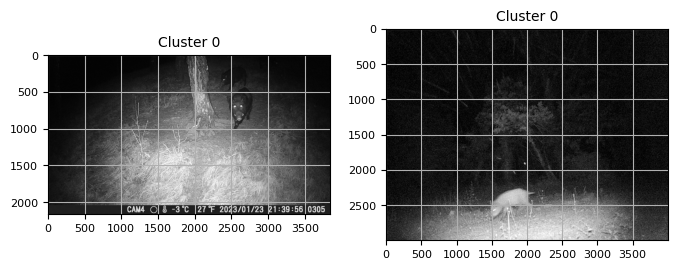

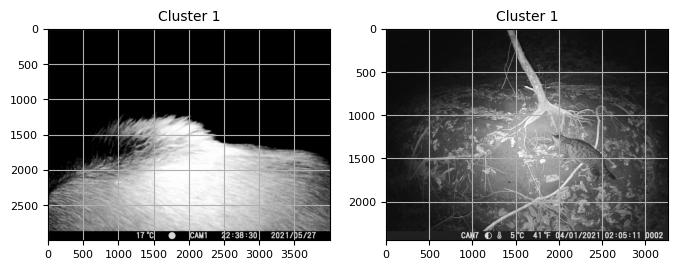

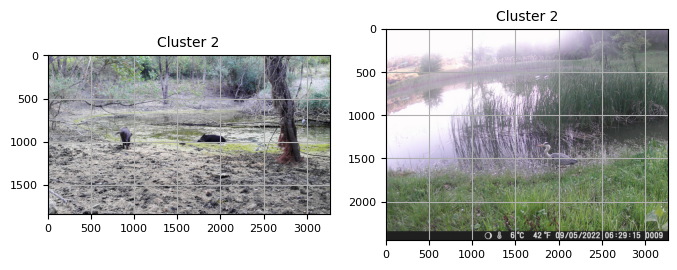

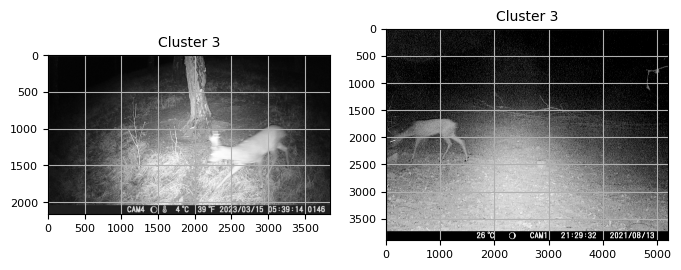

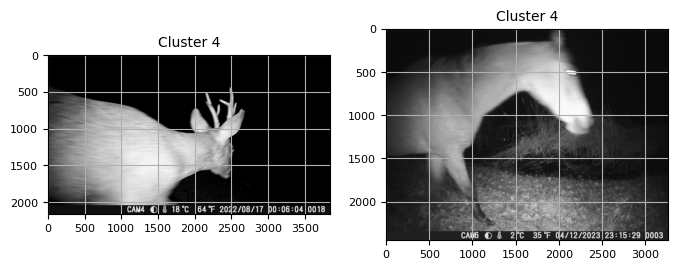

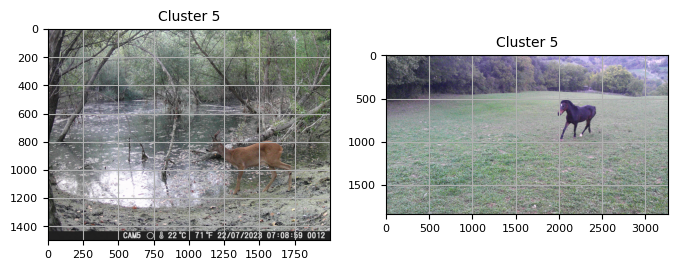

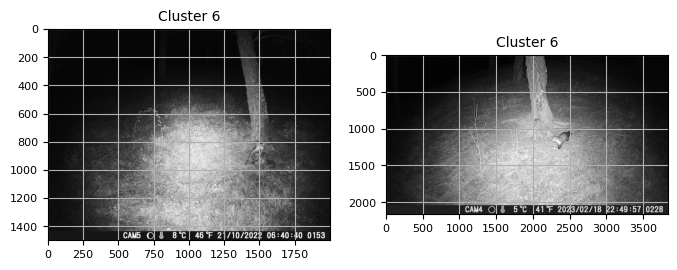

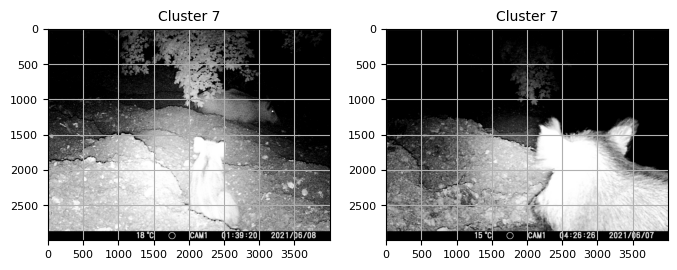

In [22]:
for i in range(n_clusters):
    cluster_indices = np.where(clusters == i)[0]

    if len(cluster_indices) < 2:
        continue

    np.random.shuffle(cluster_indices)

    cluster_images = [Image.open(image_paths[j]) for j in cluster_indices[:2]]

    f, ax = plt.subplots(1, len(cluster_images), figsize=(8, 4))
    for j, img in enumerate(cluster_images):
        ax[j].imshow(img)
        ax[j].set_title(f"Cluster {i}")
        ax[j].grid()
    plt.show()